In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from math import sqrt

# copies of dataframe read in so that maximum non-na values can be extracted from each column
df = pd.read_csv("C:\\Users\\Ronald\\Documents\\EECS_738\\Projects\\Probably_Interesting_Data\\auto-mpg.csv")

### Look at data features

In [2]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


### Look at the distribution of points for various features. Drop all 'na' values

In [3]:
displacement = df['displacement']
# pd.to_numeric(df['horsepower'], errors='ignore')
# horsepower = df['horsepower']
cylinders= df['cylinders']
weight = df['weight']
model_year = df['model year']

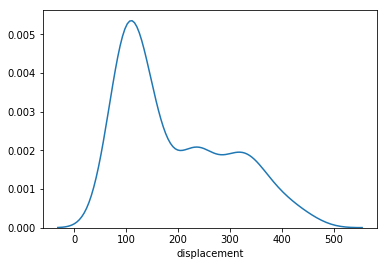

In [4]:
sns.distplot(displacement, hist=False)

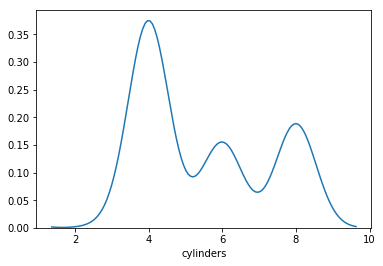

In [5]:
sns.distplot(cylinders, hist=False)

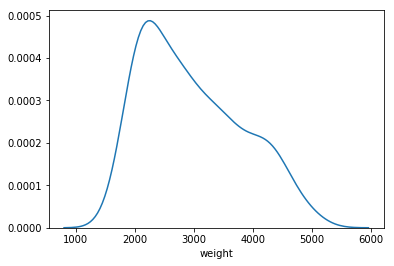

In [6]:
sns.distplot(weight, hist=False)

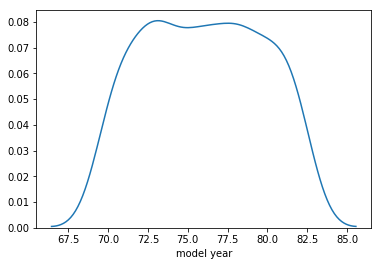

In [7]:
sns.distplot(model_year, hist=False)

### From the plots above, it can be seen that these are not pure gaussian models, but rather mixtures of gaussian models.

### It also can be observed that a gaussian mixture model composed of 2 gaussians (k = 2) would be a good fit for these distributions.

### Our goal is to find the number of models that provides the best mixtures.

In [8]:
# create a simple gaussian model
def gaussian(x, mu, sigma):
    y = np.asarray(x)
    p = norm.pdf(y, mu, sigma)
    return p

In [9]:
# convergence criterion test for the gaussian mixture model
# criterion if the updated values of mu and sigma have not increased by more than .01, then the EM algorithm has converged
def convergence_test(mu, mu_prev, sig, sig_prev):
    k = len(mu)
    mu_diff = []
    sig_diff = []
    
    # compute difference between updated and previous values for mu and sigma
    for i in range(k):
        mu_diff.append(abs(mu[i]-mu_prev[i]))
        sig_diff.append(abs(sig[i]-sig_prev[i]))
    
    # check if values of the differences meet the criterion
    mu_count = 0
    sig_count = 0
    for i in range(k):
        if(mu_diff[i] < .01):
            mu_count = mu_count + 1
        if(sig_diff[i] < .01):
            sig_count = sig_count + 1
    
    if(mu_count == k and sig_count == k):
        return True
    else:
        return False

In [10]:
# plots 1d gaussian mixture model
def colormap(x):
    N = len(x)
    k = len(x[0])
    cm = []
    
    for i in range(N):
        cm.append(x[i].index(max(x[i])))
    
    print(cm)         
    return cm

In [11]:
# create plot function for gaussian model
def plot_gaussian(z, title):
    z.sort()
    x, y = zip(*z)
    plt.plot(x,y)
    plt.title(title)

### Create a gaussian mixture model using the expectation-maximization (EM) algorithm

### Arbitrarily choose mu values by looking at original graph

### Mu values for each distribution will be stored in a dictionary that can be passed into the gaussian mixture model

In [12]:
def gaussian_mixture_model(x, k, d, title):
    # initialize values of means, variances, and mixture coefficients of gaussian models
    N = len(x)
    mix = 1/k
    mu = []
    mu_prev = []
    sig = []
    sig_prev = []
    pi_k = []
    pi_k_prev = []
    lat = []
    gaus = []
    
    # pick good starting values for mu and sig
    
    for i in range(k):
        mu.append(d[k][i])
        mu_prev.append(100)
        sig.append(100)
        sig_prev.append(100)
        pi_k.append(mix)
        lat.append([0] * N)

    # initialize guassian variable
    for i in range(k):
        gaus.append(gaussian(x, mu[i],sig[i]))
    
    # repeat E-step and M-step until convergence criterion met
    count = 0
    
    # convergence criterion for EM algorithm
    while(not convergence_test(mu, mu_prev, sig, sig_prev) or count < 50):
        # E-step 
        # compute the values of the latent variables
        for i in range(k):
            for j in range(N):
                lat_total = 0
                for l in range(k):
                    lat_total = lat_total + pi_k[l]*gaus[l][j]
                lat[i][j] = pi_k[i]*gaus[i][j]/lat_total
                
        # store prev values of means, variances for convergence testing
        mu_prev = mu.copy()
        sig_prev = sig.copy()
        pi_k_prev = pi_k.copy()
        
        
        # M-step    
        # update the values of the means, variances, and mixing cofficient
        for i in range(k):
            mu_sum = 0
            sig_sum = 0
            pi_sum = 0
            for j in range(N):
                mu_sum = mu_sum + (x[j] * lat[i][j])/sum(lat[i])
                sig_sum = sig_sum + ((x[j]-mu[i])**2 * lat[i][j])/sum(lat[i])
                pi_sum = pi_sum + lat[i][j]/N
            mu[i] = mu_sum
            sig[i] = sqrt(sig_sum)
            pi_k[i] = pi_sum
        
        # update gaussian models
        for i in range(k):
            gaus[i] = gaussian(x, mu[i], sig[i])
        
        # increase iteration
        count = count + 1
    
    # responsibilities for each sample
    resp = [ list(x) for x in zip(*lat)]
    
    y = []
    
    for i in range(N):
        p_sum = 0
        for j in range(k):
            p_sum = p_sum + pi_k[j]*gaus[j][i]
        y.append(p_sum)

    z = list(zip(x,y))
    
    # plot function
    plot_gaussian(z, title)
    
    return

### Test the GMM model on various features at the values k = 2 and k = 3

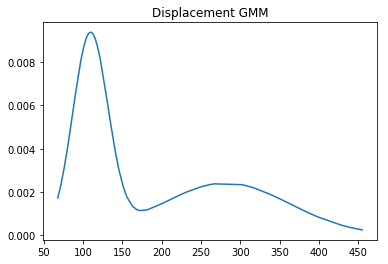

In [13]:
# displacement feature
d1 = {2:[100, 320]}
y1 = gaussian_mixture_model(displacement, 2, d1, "Displacement GMM")

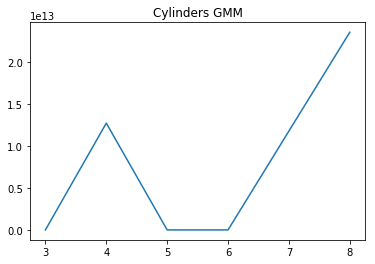

In [14]:
# cylinders feature
d2 = {3:[4, 6, 8]}
y2 = gaussian_mixture_model(cylinders, 3, d2, "Cylinders GMM")

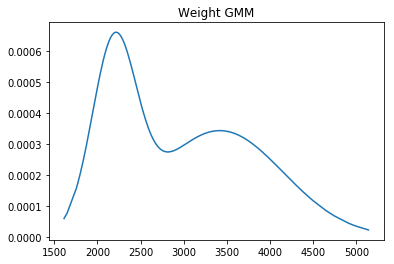

In [15]:
# weight feature
d3 = {2:[2200, 4100]}
y3 = gaussian_mixture_model(weight, 2, d3, "Weight GMM")

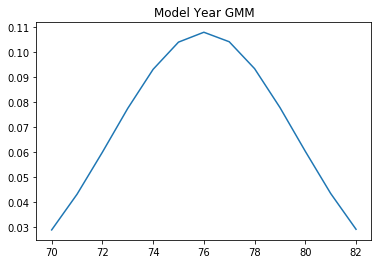

In [16]:
# model year feature
d4 = {2:[73, 78]}
y4 = gaussian_mixture_model(model_year, 2, d4, "Model Year GMM")

### It can be seen that our EM algorithm implementation did a decent job at creating GMMs

### This can most likely be attributed to the initial values of mu and sigma